# Оценка модели на наборе данных Art Goskatalog

Это тестирование ноутбука все `.pth` и `.pt` модели веса, найденные в `../DLModels` каталог на наборе данных изображения, расположенный в `../Notebooks/goskatalog_art_final`.

In [1]:
pip install ultralytics
import glob

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ilya\Documents\Ai\aienv\Scripts\python.exe -m pip install --upgrade pip


In [2]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from ultralytics import YOLO

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define paths
models_dir = os.path.join("..", "DLModels")
data_dir = os.path.join("..", "Notebooks", "goskatalog_art_final")

# Find all model weight files
model_paths = glob.glob(os.path.join(models_dir, "*.pth")) + glob.glob(os.path.join(models_dir, "*.pt"))

print(f"Found {len(model_paths)} model weights:")
for path in model_paths:
    print(os.path.basename(path))

Found 3 model weights:
efficientnet_weights.pth
resnet50_weights.pth
yolo_dropout.pt


## 1. Загрузка данных и подготовка

In [4]:
class ImageDataset(Dataset):
    """Custom dataset for loading images from a directory."""

    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        # List image files and check for debugging
        self.image_files = [
            os.path.join(directory, dirs, f)
            for dirs in os.listdir(directory)
            for f in os.listdir(os.path.join(directory, dirs))
            if f.lower().endswith(("png", "jpg", "jpeg", "bmp", "gif", "tif"))
        ]
        print(f"Searching in directory: {directory}")
        print(f"Found image files: {len(self.image_files)}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except (IOError, OSError) as e:
            print(f"Could not read image {img_path}: {e}")
            return None

        if self.transform:
            image = self.transform(image)

        return image


# Transformations for standard ImageNet models (ResNet, EfficientNet)
imagenet_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Create dataset and dataloader for classification models
full_dataset = ImageDataset(data_dir, transform=imagenet_transform)
data_loader = DataLoader(full_dataset, batch_size=4, shuffle=True)

# Get all image paths for YOLO
all_image_paths = [
    (os.path.join(data_dir, dirs, f), dirs)
    for dirs in os.listdir(data_dir)
    for f in os.listdir(os.path.join(data_dir, dirs))
    if f.lower().endswith(("png", "jpg", "jpeg"))
]

print(f"Loaded {len(full_dataset)} images for testing.")

Searching in directory: ..\Notebooks\goskatalog_art_final
Found image files: 1274
Loaded 1274 images for testing.


In [5]:
all_image_paths[1]

('..\\Notebooks\\goskatalog_art_final\\Абрикос\\17234527.jpg', 'Абрикос')

## 2. Модель и вывод

In [6]:
random.sample(all_image_paths, min(4, len(all_image_paths)))

[('..\\Notebooks\\goskatalog_art_final\\Груша\\27222649.jpg', 'Груша'),
 ('..\\Notebooks\\goskatalog_art_final\\Клубник\\28217866.jpg', 'Клубник'),
 ('..\\Notebooks\\goskatalog_art_final\\Арбуз\\31939607.jpg', 'Арбуз'),
 ('..\\Notebooks\\goskatalog_art_final\\Груша\\35159151.jpg', 'Груша')]


--- Testing efficientnet_weights.pth ---
Unknown model architecture for efficientnet_weights.pth. Skipping.

--- Testing resnet50_weights.pth ---
Loading ResNet50 architecture...
Running inference on a sample batch...


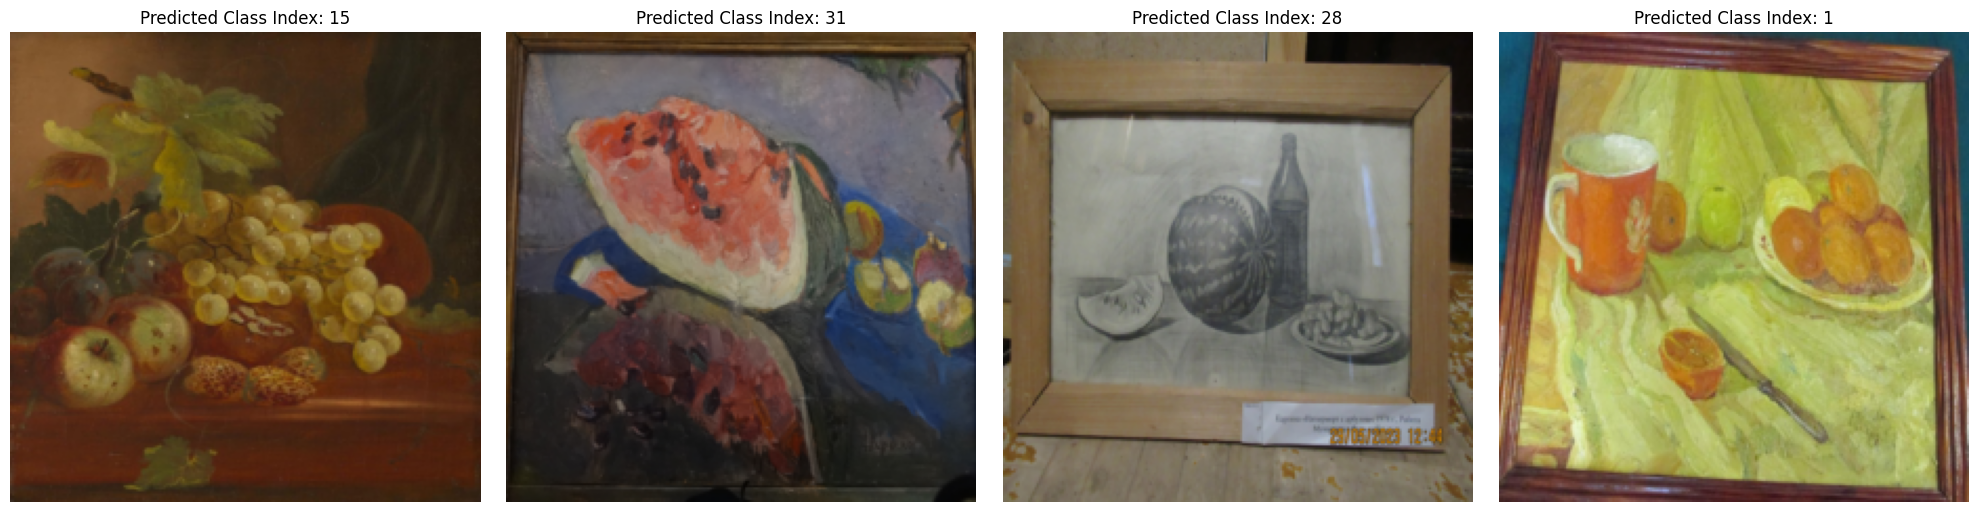


--- Testing yolo_dropout.pt ---
Unknown model architecture for yolo_dropout.pt. Skipping.

--- All models tested. ---


In [7]:
def show_results(images, titles):
    """Helper function to display images with titles."""
    num_images = len(images)
    # Create a figure with a flexible number of subplots
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
    if num_images == 1:  # If there's only one image, axes is not a list
        axes = [axes]
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


for model_path in model_paths:
    model_name = os.path.basename(model_path)
    print(f"\n--- Testing {model_name} ---")

    try:
        model = None
        is_yolo = False

        if "resnet50" in model_name.lower():
            print("Loading ResNet50 architecture...")
            model = torchvision.models.resnet50(weights=None)  # Load without pre-trained weights
            # The error indicates the saved model has 32 output classes
            num_ftrs = model.fc.in_features
            model.fc = torch.nn.Linear(num_ftrs, 32)
            model.load_state_dict(torch.load(model_path, map_location=device))
            loader = data_loader

        # elif "efficientnet" in model_name.lower():
        #     print("Loading EfficientNet_B0 architecture...")
        #     model = torchvision.models.efficientnet_b0(weights=None)  # Load without pre-trained weights
        #     # The error indicates the saved model has 256 output classes
        #     num_ftrs = model.classifier[1].in_features
        #     model.classifier[1] = torch.nn.Linear(num_ftrs, 256)
        #     # Use strict=False to ignore non-matching keys like 'classifier.3...' etc.
        #     model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
        #     loader = data_loader

        # elif "yolo" in model_name.lower():
        #     print("Loading YOLO model...")
        #     is_yolo = True
        #     model = YOLO(model_path)

        else:
            print(f"Unknown model architecture for {model_name}. Skipping.")
            continue

        if not is_yolo:
            model.to(device)
            model.eval()

        print("Running inference on a sample batch...")
        with torch.no_grad():
            if is_yolo:
                # For YOLO, we pass a list of image paths directly
                sample_paths = random.sample(all_image_paths, min(4, len(all_image_paths)))
                ans = []
                path_ = []
                for pa, class_ in sample_paths:
                    ans.append(class_)
                    path_.append(pa)
                sample_paths = path_
                results = model(sample_paths, verbose=False)
                for i, _ in enumerate(results):
                    if ans[i] == results[i].to_df().iloc[0, 0]:
                        ans[i] += "=True"
                    else:
                        ans[i] += "=False"
                plotted_images = [r.plot() for r in results]  # .plot() returns a BGR numpy array
                # Convert BGR to RGB for matplotlib
                plotted_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in plotted_images]
                titles = [f"YOLO Prediction {i+1}" for i in range(len(results))]
                show_results(plotted_images_rgb, ans)
            else:
                # For classification models, use the data loader
                tensor_batch = next(iter(loader))
                if tensor_batch is None:
                    print("Could not load a batch of images. Skipping model.")
                    continue

                outputs = model(tensor_batch.to(device))
                _, preds = torch.max(outputs, 1)

                titles = [f"Predicted Class Index: {p.item()}" for p in preds]

                # Un-normalize images for display
                display_images = []
                for img_tensor in tensor_batch:
                    img_tensor = img_tensor.cpu().numpy().transpose((1, 2, 0))
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img_tensor = std * img_tensor + mean
                    img_tensor = np.clip(img_tensor, 0, 1)
                    display_images.append(img_tensor)
                show_results(display_images, titles)

    except Exception as e:
        print(f"An error occurred while testing {model_name}: {e}")

print("\n--- All models tested. ---")